In [14]:
!pip install tensorflow
!pip install scikit-learn

# Imports

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error


In [50]:
import sys
sys.path.append('../../') 
from utilities import dataframe_utils as dfu

In [51]:
data_df = dfu.load_data("../../data/raw_data/sp500_adj_close_raw.zip")
# data_df = dfu.load_data("../../data/old_data/sp500_adj_close_raw_10_21.zip")

╔═══════════════════════════════════════════════════════════════╗
║     File `test.csv` loaded from `sp500_adj_close_raw.zip`     ║
╚═══════════════════════════════════════════════════════════════╝


In [54]:
# # Load stock data
# data_df = pd.read_csv('/Users/montredavis/Desktop/rice_ai_bootcamp/projects/Group_project_2/data/raw_data/sp500_adj_close_raw.csv', index_col=0)
# data_df.head()
data_df.sort_values(by='Date', ascending=True, inplace=True)
data_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance,Action
0,2023-10-24 00:00:00+00:00,A,104.928497,-0.021204,0.025799,0.0,121.677983,128.300623,133.159750,115.267511,98.748274,100.488594,138.878311,buy
311,2023-10-24 00:00:00+00:00,MOH,333.769989,0.008030,0.014216,100.0,357.502201,370.563300,354.020950,371.173670,321.991333,327.980011,382.390015,sell
337,2023-10-24 00:00:00+00:00,NSC,191.539688,-0.053251,0.015819,0.0,210.678894,227.312352,229.523306,209.829507,174.959969,180.110168,232.515091,short
336,2023-10-24 00:00:00+00:00,NRG,40.927116,-0.005705,0.017718,0.0,46.314433,50.116608,62.858020,48.475337,39.459898,40.528255,50.906609,buy
335,2023-10-24 00:00:00+00:00,NOW,554.390015,-0.043688,0.016941,0.0,657.594197,709.080998,729.244699,689.153804,526.809190,530.169983,716.479980,buy


## Set Indices

In [55]:
data_df = data_df.drop(columns=['Action'])
data_df.set_index(['Date', 'Ticker'], inplace=True)

In [56]:
data_df.head()

Adjusted Close    Return  Volatility    RSI  \
Date                      Ticker                                                
2023-10-24 00:00:00+00:00 A           104.928497 -0.021204    0.025799    0.0   
                          MOH         333.769989  0.008030    0.014216  100.0   
                          NSC         191.539688 -0.053251    0.015819    0.0   
                          NRG          40.927116 -0.005705    0.017718    0.0   
                          NOW         554.390015 -0.043688    0.016941    0.0   

                                      SMA_50     SMA_100     SMA_200  \
Date                      Ticker                                       
2023-10-24 00:00:00+00:00 A       121.677983  128.300623  133.159750   
                          MOH     357.502201  370.563300  354.020950   
                          NSC     210.678894  227.312352  229.523306   
                          NRG      46.314433   50.116608   62.858020   
                          NOW     657.594197  709.080998  729.244699   

                                  Upper Band  Lower Band     Support  \
Date                      Ticker                                       
2023-10-24 00:00:00+00:00 A       115.267511   98.748274  100.488594   
                          MOH     371.173670  321.991333  327.980011   
                          NSC     209.829507  174.959969  180.110168   
                          NRG      48.475337   39.459898   40.528255   
                          NOW     689.153804  526.809190  530.169983   

                                  Resistance  
Date                      Ticker              
2023-10-24 00:00:00+00:00 A       138.878311  
                          MOH     382.390015  
                          NSC     232.515091  
                          NRG      50.906609  
                          NOW     716.479980

In [36]:
data_df.shape

(124109, 11)

In [37]:
# Create features and target
X = data_df.drop(columns=['Return'])  # 'target' is the column you're predicting
y = data_df['Return']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data (neural networks usually perform better when features are scaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Neural Networks

In [32]:


# Define the neural network architecture
model = Sequential()

# Add layers: Input layer, hidden layers, and output layer
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Input layer and first hidden layer
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, validation_data=(X_test_scaled, y_test), epochs=50, batch_size=32)


Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3103/3103 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - loss: 0.0050 - mae: 0.0247 - val_loss: 4.8630e-04 - val_mae: 0.0140
Epoch 2/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 391us/step - loss: 3.9810e-04 - mae: 0.0131 - val_loss: 3.6058e-04 - val_mae: 0.0126
Epoch 3/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 388us/step - loss: 4.0064e-04 - mae: 0.0127 - val_loss: 3.9712e-04 - val_mae: 0.0126
Epoch 4/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 3.2719e-04 - mae: 0.0120 - val_loss: 3.4387e-04 - val_mae: 0.0121
Epoch 5/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 410us/step - loss: 3.2655e-04 - mae: 0.0119 - val_loss: 3.4054e-04 - val_mae: 0.0121
Epoch 6/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 3.0839e-04 - mae: 0.0118 - val_loss: 3.4083e-04 - val_mae: 0.0121
Epoch 7/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 379us/step - loss: 3.5599e-04 - mae: 0.0120 - val_loss: 3.4102e-04 - val_mae: 0.0121
Epoch 8/50
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - loss: 3.1694e-04 - mae: 0.0119 - val_loss: 3.40

In [33]:
history.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,453 (33.02 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,636 (22.02 KB)

In [38]:
# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test_scaled, y_test)

print(f"Test Mean Absolute Error: {test_mae}")
print(f"Test Loss: {test_loss}")

776/776 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step - loss: 3.4833e-04 - mae: 0.0121
Test Mean Absolute Error: 0.012131692841649055
Test Loss: 0.0003435580001678318


## Logistic Regression

In [39]:


# For logistic regression, you might want to binarize the target (e.g., predict up/down movement)
y_train_binary = (y_train > y_train.median()).astype(int)
y_test_binary = (y_test > y_test.median()).astype(int)

# Fit logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train_binary)

# Predict on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate logistic regression model
mse_log_reg = mean_squared_error(y_test_binary, y_pred_log_reg)
print(f"Logistic Regression Mean Squared Error: {mse_log_reg}")


Logistic Regression Mean Squared Error: 0.4813471920070905


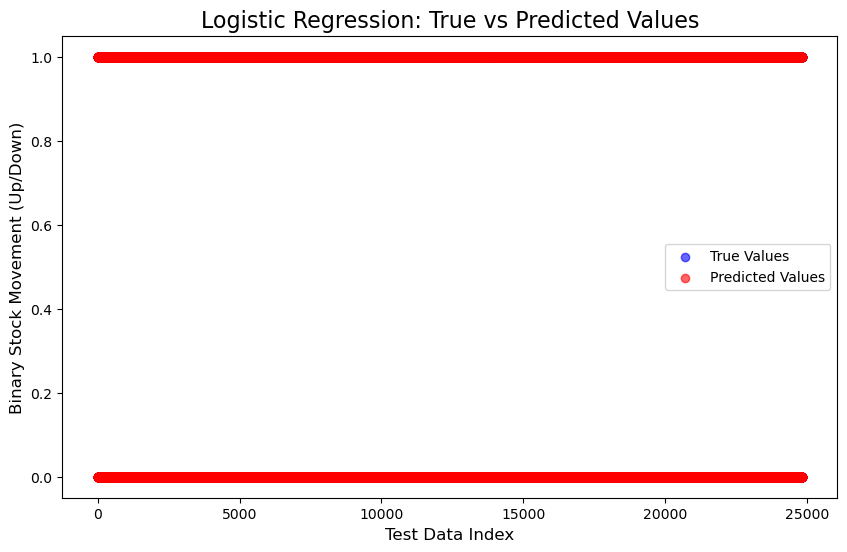

In [41]:
import matplotlib.pyplot as plt

# Create a scatter plot for visualizing predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test_binary)), y_test_binary, color='blue', label='True Values', alpha=0.6)
plt.scatter(range(len(y_pred_log_reg)), y_pred_log_reg, color='red', label='Predicted Values', alpha=0.6)

# Add title and labels
plt.title('Logistic Regression: True vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Index', fontsize=12)
plt.ylabel('Binary Stock Movement (Up/Down)', fontsize=12)
plt.legend()

# Display the plot
plt.show()

In [26]:
# MAE for Neural Network
_, neural_net_mae = model.evaluate(X_test_scaled, y_test)

# MAE for Logistic Regression (you may need to adjust this to accuracy if it’s a binary classification)
from sklearn.metrics import accuracy_score
log_reg_accuracy = accuracy_score(y_test_binary, y_pred_log_reg)

print(f"Neural Network MAE: {neural_net_mae}")
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")


779/779 ━━━━━━━━━━━━━━━━━━━━ 0s 258us/step - loss: 1.6795e-04 - mae: 0.0083
Neural Network MAE: 0.008276415057480335
Logistic Regression Accuracy: 0.9558622903458791
